In [1]:
DATAPATH = '../data/'
XFERPATH = '~/gdrive_files/twitgen/'  # To transfer files from Google Colab
TRAIN_FNAME = 'embed_train_201906142054.csv'
VALID_FNAME = 'embed_valid_201906142054.csv'
TEST_FNAME = 'embed_test_201906142054.csv'
MODEL_TYPE_ID = 'lrp'

In [2]:
train_from = XFERPATH + TRAIN_FNAME
valid_from = XFERPATH + VALID_FNAME
test_from = XFERPATH + TEST_FNAME
!cp $train_from $DATAPATH
!cp $valid_from $DATAPATH
!cp $test_from $DATAPATH

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from datetime import datetime

In [4]:
timestamp = datetime.now().strftime('%Y%m%d%H%M')
timestamp

'201906141723'

In [5]:
df_train = pd.read_csv(DATAPATH+TRAIN_FNAME, index_col=[0,1], parse_dates=['time'])
df_valid = pd.read_csv(DATAPATH+VALID_FNAME, index_col=[0,1], parse_dates=['time'])
df_test = pd.read_csv(DATAPATH+TEST_FNAME, index_col=[0,1], parse_dates=['time'])
df_train.head().iloc[:,:7]

,,male,embed0,embed1,embed2,embed3,embed4,embed5
id,time,,,,,,,
1083596943807393792,2019-05-27 23:27:08+00:00,True,116,77182,20189,20846,11,18693
815783987784187904,2019-05-24 15:36:01+00:00,False,-10180,-54973,23295,-20926,-2923,10973
3458239641,2019-05-24 19:00:37+00:00,False,-47975,-25760,12054,57238,18813,29521
1003729876250226688,2019-05-26 12:53:00+00:00,True,-13465,74146,9292,102728,7242,-46039
2360143940,2019-05-28 03:50:46+00:00,False,1160,-2419,-48361,36310,47470,-31694


In [6]:
print(df_train.shape, df_valid.shape, df_test.shape)
print(df_train.index.get_level_values(1).min(), df_train.index.get_level_values(1).max())
print(df_valid.index.get_level_values(1).min(), df_valid.index.get_level_values(1).max())
print(df_test.index.get_level_values(1).min(), df_test.index.get_level_values(1).max())

(34146, 513) (10914, 513) (10450, 513)
2019-05-21 17:50:48+00:00 2019-05-28 12:44:26+00:00
2019-05-28 12:44:27+00:00 2019-05-30 12:09:54+00:00
2019-05-30 12:10:02+00:00 2019-06-01 19:55:43+00:00


In [7]:
def getxy(df):
    X = df.drop(['male'],axis=1).values / 1e6
    y = 1*df.male.values
    return(X, y)
    
X_train, y_train = getxy(df_train)
X_valid, y_valid = getxy(df_valid)
X_test, y_test = getxy(df_test)

In [8]:
pca = PCA(64)
pca.fit(X_train)
print(pca.explained_variance_ratio_)

[0.0767009  0.04940694 0.03212662 0.02723306 0.02694522 0.02254503
 0.02087141 0.01886975 0.01819184 0.01773331 0.01694228 0.01547141
 0.01519448 0.01453913 0.01386597 0.01337477 0.01296537 0.01205305
 0.01185657 0.01154208 0.01106194 0.0108754  0.01066757 0.01058834
 0.01018948 0.00972788 0.00956501 0.00927467 0.00898695 0.00867132
 0.00855854 0.00817398 0.00795549 0.00791643 0.00774393 0.00759224
 0.00751189 0.00741186 0.00725598 0.00720991 0.00700159 0.00687271
 0.00664638 0.00656294 0.00647924 0.00630644 0.00624454 0.00616624
 0.00604362 0.00591292 0.00580554 0.00573542 0.00569054 0.00565312
 0.00548497 0.00545792 0.00529959 0.0052467  0.00518911 0.00506859
 0.00491823 0.00484864 0.00478624 0.00476331]


In [9]:
model = Pipeline([('pca',  PCA(50)),
                  ('poly', PolynomialFeatures()),
                  ('lr',   LogisticRegression(C=.08))])
model = model.fit(X_train, y_train)

/Users/andy/anaconda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [10]:
def save_predictions(df, predictions, which_set):
    pred_df = df[['male']].copy()
    pred_df['pred'] = predictions
    path = DATAPATH + MODEL_TYPE_ID + '_' + which_set + '_pred_' + timestamp + '.csv'
    pred_df.to_csv(path)    

In [11]:
y_train_pred = model.predict_proba(X_train)[:,1]
save_predictions(df_train, y_train_pred, 'train')
f1_score(y_train, y_train_pred>.5)

0.707300658376006

In [12]:
y_pred = model.predict_proba(X_valid)[:,1]
save_predictions(df_valid, y_pred, 'valid')
print( confusion_matrix(y_valid, (y_pred>.5)) )
f1_score(y_valid, y_pred>.5)

[[3331 2126]
 [1929 3528]]


0.6350463504635048

In [13]:
accuracy_score(y_valid, y_pred>.5)

0.6284588601795859

In [14]:
y_test_pred = model.predict_proba(X_test)[:,1]
save_predictions(df_test, y_test_pred, 'test')
print( confusion_matrix(y_test, (y_test_pred>.5)) )
f1_score(y_test, y_test_pred>.5)

[[3146 2079]
 [1873 3352]]


0.6291291291291292

In [15]:
accuracy_score(y_test, y_test_pred>.5)

0.6218181818181818

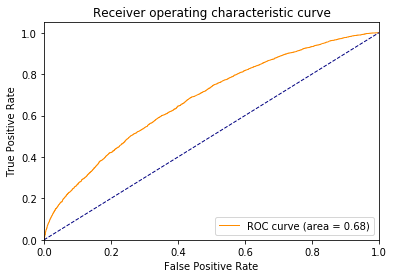

In [16]:
fpr, tpr, _ = roc_curve(y_test, y_test_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic curve')
plt.legend(loc="lower right")
plt.show()

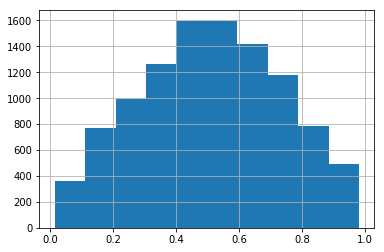

In [17]:
pd.Series(y_test_pred).hist()
plt.show()

In [18]:
df_acc = pd.DataFrame(columns=['minprob','maxprob','count','accuracy'])
for pbot in np.linspace(0,.9,10):
    ptop = pbot+.1
    mask = (y_test_pred>=pbot)&(y_test_pred<ptop)
    count = int(mask.sum())
    acc = accuracy_score(y_test[mask], y_test_pred[mask]>.5)
    row = pd.DataFrame({'minprob':[pbot], 'maxprob':[ptop], 'count':[count], 'accuracy':[acc]})
    df_acc = pd.concat([df_acc, row])
df_acc.set_index(['minprob','maxprob'])

,,count,accuracy
minprob,maxprob,,
0.0,0.1,300,0.856667
0.1,0.2,750,0.742667
0.2,0.3,1016,0.675197
0.3,0.4,1307,0.591431
0.4,0.5,1646,0.530377
0.5,0.6,1647,0.510625
0.6,0.7,1429,0.594122
0.7,0.8,1186,0.625632
0.8,0.9,777,0.742600


In [19]:
from joblib import dump
model_path = DATAPATH + MODEL_TYPE_ID + '_model_' + timestamp + '.joblib'
dump(model, model_path)

['../data/lrp_model_201906141723.joblib']